In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 627.2161, train_label_loss: 2.8216, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11740.5013, train_label_loss: 2.7149, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11605.1377, train_label_loss: 2.6033, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11809.8264, train_label_loss: 2.5202, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11820.3367, train_label_loss: 2.2961, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11652.2316, train_label_loss: 2.1301, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11569.2346, train_label_loss: 2.0507, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11699.2941, train_label_loss: 1.7957, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11601.9258, train_label_loss: 1.7544, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11724.8042, train_label_loss: 1.4919, 


epoch: 1, source_val_acc_label: 0.6123, source_val_label_loss: 1.3601, target_val_acc_label: 0.5710, target_val_label_loss: 1.4615, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 53.6965, train_label_loss: 1.4574, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11594.9183, train_label_loss: 1.3813, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11297.1942, train_label_loss: 1.2111, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11933.4917, train_label_loss: 1.1166, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11630.6955, train_label_loss: 1.1297, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11668.9017, train_label_loss: 0.9913, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11595.2157, train_label_loss: 0.9396, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11501.7471, train_label_loss: 0.9316, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11514.1602, train_label_loss: 0.7211, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11606.7273, train_label_loss: 0.6586, 


epoch: 2, source_val_acc_label: 0.8549, source_val_label_loss: 0.6369, target_val_acc_label: 0.7765, target_val_label_loss: 0.8560, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 63.6742, train_label_loss: 0.7573, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11573.0346, train_label_loss: 0.6301, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11602.5007, train_label_loss: 0.6593, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11343.1437, train_label_loss: 0.6105, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11665.7920, train_label_loss: 0.5531, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11783.1344, train_label_loss: 0.4198, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11474.2608, train_label_loss: 0.4471, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11505.5801, train_label_loss: 0.4533, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11583.2396, train_label_loss: 0.4251, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11576.2267, train_label_loss: 0.4470, 


epoch: 3, source_val_acc_label: 0.9046, source_val_label_loss: 0.3884, target_val_acc_label: 0.8097, target_val_label_loss: 0.6580, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 64.1574, train_label_loss: 0.3236, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 12163.3555, train_label_loss: 0.3472, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 12354.5493, train_label_loss: 0.3789, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 12653.5104, train_label_loss: 0.3031, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 12164.4410, train_label_loss: 0.8126, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 10521.5889, train_label_loss: 0.3123, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 10511.2654, train_label_loss: 0.4826, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 10657.6896, train_label_loss: 0.3568, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 10574.0417, train_label_loss: 0.4031, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 10610.1360, train_label_loss: 0.3626, 


epoch: 4, source_val_acc_label: 0.9237, source_val_label_loss: 0.2948, target_val_acc_label: 0.8345, target_val_label_loss: 0.5795, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 56.8264, train_label_loss: 0.3152, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 10588.9159, train_label_loss: 0.3342, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 10710.3517, train_label_loss: 0.3700, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 10661.5658, train_label_loss: 0.3175, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 10752.5978, train_label_loss: 0.3126, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 10706.3621, train_label_loss: 0.4035, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 10728.7081, train_label_loss: 0.2009, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 10667.4550, train_label_loss: 0.3454, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 10669.2842, train_label_loss: 0.2664, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 10714.0097, train_label_loss: 0.2881, 


epoch: 5, source_val_acc_label: 0.9340, source_val_label_loss: 0.2551, target_val_acc_label: 0.8351, target_val_label_loss: 0.5540, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 56.3162, train_label_loss: 0.2459, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 10594.2465, train_label_loss: 0.2756, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 10678.3957, train_label_loss: 0.2464, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 10626.7302, train_label_loss: 0.3513, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 10710.4417, train_label_loss: 0.1501, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 10661.2966, train_label_loss: 0.1779, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 10617.6196, train_label_loss: 0.2939, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 10705.5570, train_label_loss: 0.3865, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 10651.0036, train_label_loss: 0.2128, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 10707.3322, train_label_loss: 0.2631, 


epoch: 6, source_val_acc_label: 0.9301, source_val_label_loss: 0.2279, target_val_acc_label: 0.8456, target_val_label_loss: 0.5668, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 57.2451, train_label_loss: 0.2471, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 10633.6082, train_label_loss: 0.2604, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 10651.7085, train_label_loss: 0.1593, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 10741.1592, train_label_loss: 0.2438, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 10707.3169, train_label_loss: 0.2972, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 10602.0916, train_label_loss: 0.1802, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 10682.2308, train_label_loss: 0.2435, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 10563.7769, train_label_loss: 0.2200, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 10752.0395, train_label_loss: 0.2741, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 10633.8988, train_label_loss: 0.2090, 


epoch: 7, source_val_acc_label: 0.9484, source_val_label_loss: 0.1768, target_val_acc_label: 0.8481, target_val_label_loss: 0.6565, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 56.6678, train_label_loss: 0.1899, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 10666.4320, train_label_loss: 0.2294, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 10703.4851, train_label_loss: 0.1945, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 10938.4466, train_label_loss: 0.1402, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11534.0097, train_label_loss: 0.1517, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11727.8576, train_label_loss: 0.1565, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11749.3127, train_label_loss: 0.1416, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11787.4770, train_label_loss: 0.1714, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11683.9719, train_label_loss: 0.2177, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11683.5941, train_label_loss: 0.2893, 


epoch: 8, source_val_acc_label: 0.9390, source_val_label_loss: 0.1943, target_val_acc_label: 0.8428, target_val_label_loss: 0.6521, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 65.0009, train_label_loss: 0.3681, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11556.9006, train_label_loss: 0.1361, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11724.1129, train_label_loss: 0.1280, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11667.0849, train_label_loss: 0.1206, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11625.1280, train_label_loss: 0.1866, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11663.8640, train_label_loss: 0.1760, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11856.5401, train_label_loss: 0.2076, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11731.7402, train_label_loss: 0.1808, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11710.5699, train_label_loss: 0.1793, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11564.5246, train_label_loss: 0.1955, 


epoch: 9, source_val_acc_label: 0.9485, source_val_label_loss: 0.1794, target_val_acc_label: 0.8540, target_val_label_loss: 0.7443, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 64.4719, train_label_loss: 0.2457, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11680.4307, train_label_loss: 0.1949, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11722.1253, train_label_loss: 0.1351, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11720.4930, train_label_loss: 0.0869, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11758.2622, train_label_loss: 0.1133, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 12155.2913, train_label_loss: 0.0793, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11608.9269, train_label_loss: 0.1326, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11692.5892, train_label_loss: 0.1144, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11754.6524, train_label_loss: 0.1758, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11626.6007, train_label_loss: 0.1219, 


epoch: 10, source_val_acc_label: 0.9444, source_val_label_loss: 0.1830, target_val_acc_label: 0.8476, target_val_label_loss: 0.6348, 


epoch: 11, [batch: 1 / 1400], examples_per_second: 64.1048, train_label_loss: 0.1174, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 11526.9229, train_label_loss: 0.1557, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 11728.8038, train_label_loss: 0.0461, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 11773.6177, train_label_loss: 0.2169, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 11775.5490, train_label_loss: 0.1612, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 11672.1834, train_label_loss: 0.1249, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 11712.3619, train_label_loss: 0.0829, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 11762.3508, train_label_loss: 0.0922, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 11709.7745, train_label_loss: 0.1653, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 11688.7379, train_label_loss: 0.1196, 


epoch: 11, source_val_acc_label: 0.9536, source_val_label_loss: 0.1561, target_val_acc_label: 0.8551, target_val_label_loss: 0.6199, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 63.7992, train_label_loss: 0.1093, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 11602.1922, train_label_loss: 0.1189, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 11750.0198, train_label_loss: 0.1575, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 11688.5252, train_label_loss: 0.0779, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 12452.9221, train_label_loss: 0.1102, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 12499.4496, train_label_loss: 0.1757, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 12512.1527, train_label_loss: 0.1201, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 12742.7006, train_label_loss: 0.1854, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 10685.1161, train_label_loss: 0.0929, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 10725.8726, train_label_loss: 0.1262, 


epoch: 12, source_val_acc_label: 0.9524, source_val_label_loss: 0.1406, target_val_acc_label: 0.8539, target_val_label_loss: 0.5759, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 57.2071, train_label_loss: 0.1782, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 10644.5305, train_label_loss: 0.1204, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 10656.4112, train_label_loss: 0.1194, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 10658.7475, train_label_loss: 0.1100, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 10738.1070, train_label_loss: 0.1178, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 10648.1940, train_label_loss: 0.1166, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 10745.9290, train_label_loss: 0.1143, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 10717.5097, train_label_loss: 0.2219, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 10671.0443, train_label_loss: 0.1586, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 10710.6630, train_label_loss: 0.0872, 


epoch: 13, source_val_acc_label: 0.9608, source_val_label_loss: 0.1349, target_val_acc_label: 0.8575, target_val_label_loss: 0.6142, 


New best
epoch: 14, [batch: 1 / 1400], examples_per_second: 57.0799, train_label_loss: 0.1013, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 10733.0740, train_label_loss: 0.1695, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 10593.6398, train_label_loss: 0.1062, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 10708.3863, train_label_loss: 0.0867, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 10692.0534, train_label_loss: 0.1172, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 10709.2437, train_label_loss: 0.1181, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 10639.5887, train_label_loss: 0.1163, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 10731.6140, train_label_loss: 0.1292, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 10735.4414, train_label_loss: 0.0688, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 10624.4275, train_label_loss: 0.1010, 


epoch: 14, source_val_acc_label: 0.9517, source_val_label_loss: 0.1445, target_val_acc_label: 0.8538, target_val_label_loss: 0.5699, 


epoch: 15, [batch: 1 / 1400], examples_per_second: 57.5139, train_label_loss: 0.1342, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 10585.0649, train_label_loss: 0.1132, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 10727.0789, train_label_loss: 0.1194, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 10728.7111, train_label_loss: 0.0575, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 10695.8268, train_label_loss: 0.0764, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 10713.1087, train_label_loss: 0.0740, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 10709.2376, train_label_loss: 0.1165, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 10709.0057, train_label_loss: 0.0648, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 10648.6330, train_label_loss: 0.0685, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 10718.0110, train_label_loss: 0.1232, 


epoch: 15, source_val_acc_label: 0.9585, source_val_label_loss: 0.1249, target_val_acc_label: 0.8506, target_val_label_loss: 0.6029, 


epoch: 16, [batch: 1 / 1400], examples_per_second: 57.8469, train_label_loss: 0.1415, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 10713.9570, train_label_loss: 0.0983, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 10690.7394, train_label_loss: 0.1284, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 10714.7321, train_label_loss: 0.1327, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 10707.5198, train_label_loss: 0.0997, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 10552.1452, train_label_loss: 0.1327, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 10609.7736, train_label_loss: 0.0957, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 10789.6184, train_label_loss: 0.1257, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 10666.6269, train_label_loss: 0.1626, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 10570.6511, train_label_loss: 0.0676, 


epoch: 16, source_val_acc_label: 0.9581, source_val_label_loss: 0.1403, target_val_acc_label: 0.8593, target_val_label_loss: 0.6117, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 57.0931, train_label_loss: 0.0942, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 10670.5240, train_label_loss: 0.1657, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 10569.9941, train_label_loss: 0.0672, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 10632.0065, train_label_loss: 0.1132, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 10654.4143, train_label_loss: 0.1381, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 10728.1415, train_label_loss: 0.1372, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 10709.4284, train_label_loss: 0.2511, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 10572.0829, train_label_loss: 0.1137, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 10698.6098, train_label_loss: 0.1426, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 10815.8937, train_label_loss: 0.0703, 


epoch: 17, source_val_acc_label: 0.9596, source_val_label_loss: 0.3663, target_val_acc_label: 0.8564, target_val_label_loss: 1.2324, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 57.5707, train_label_loss: 0.0540, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 10613.7867, train_label_loss: 0.0557, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 10723.1090, train_label_loss: 0.0628, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 10731.8913, train_label_loss: 0.0976, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 10710.8294, train_label_loss: 0.0792, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 10777.3900, train_label_loss: 0.0964, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 10732.4077, train_label_loss: 0.0676, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 10700.1984, train_label_loss: 0.0666, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 10731.3091, train_label_loss: 0.0957, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 10738.4906, train_label_loss: 0.0828, 


epoch: 18, source_val_acc_label: 0.9621, source_val_label_loss: 0.2046, target_val_acc_label: 0.8532, target_val_label_loss: 0.9064, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 57.0607, train_label_loss: 0.0660, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 10686.9788, train_label_loss: 0.1108, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 10687.9437, train_label_loss: 0.0722, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 10679.5109, train_label_loss: 0.1064, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 10674.6786, train_label_loss: 0.1036, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 10668.5088, train_label_loss: 0.0758, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 10748.4461, train_label_loss: 0.1244, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 10683.6733, train_label_loss: 0.0839, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 10605.8871, train_label_loss: 0.0660, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 10707.0896, train_label_loss: 0.0453, 


epoch: 19, source_val_acc_label: 0.9486, source_val_label_loss: 0.1988, target_val_acc_label: 0.8509, target_val_label_loss: 0.8938, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 63.9403, train_label_loss: 0.0787, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 11715.4603, train_label_loss: 0.0661, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 11742.9044, train_label_loss: 0.0752, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 11784.7380, train_label_loss: 0.0473, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 11712.2506, train_label_loss: 0.0481, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 11784.0507, train_label_loss: 0.0653, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 11756.2318, train_label_loss: 0.0538, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 11728.7488, train_label_loss: 0.0746, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 11716.8644, train_label_loss: 0.0696, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 11718.0152, train_label_loss: 0.1281, 


epoch: 20, source_val_acc_label: 0.9606, source_val_label_loss: 0.3106, target_val_acc_label: 0.8630, target_val_label_loss: 1.1725, 


New best
epoch: 21, [batch: 1 / 1400], examples_per_second: 62.8357, train_label_loss: 0.0402, 


epoch: 21, [batch: 140 / 1400], examples_per_second: 11727.4403, train_label_loss: 0.0624, 


epoch: 21, [batch: 280 / 1400], examples_per_second: 11733.9289, train_label_loss: 0.0721, 


epoch: 21, [batch: 420 / 1400], examples_per_second: 11655.7154, train_label_loss: 0.0562, 


epoch: 21, [batch: 560 / 1400], examples_per_second: 11670.2931, train_label_loss: 0.0695, 


epoch: 21, [batch: 700 / 1400], examples_per_second: 11766.6358, train_label_loss: 0.0715, 


epoch: 21, [batch: 840 / 1400], examples_per_second: 11747.4304, train_label_loss: 0.0828, 


epoch: 21, [batch: 980 / 1400], examples_per_second: 11741.4406, train_label_loss: 0.0784, 


epoch: 21, [batch: 1120 / 1400], examples_per_second: 11838.7408, train_label_loss: 0.0694, 


epoch: 21, [batch: 1260 / 1400], examples_per_second: 11757.6938, train_label_loss: 0.0772, 


epoch: 21, source_val_acc_label: 0.9668, source_val_label_loss: 0.0989, target_val_acc_label: 0.8645, target_val_label_loss: 0.6352, 


New best
epoch: 22, [batch: 1 / 1400], examples_per_second: 65.0129, train_label_loss: 0.0514, 


epoch: 22, [batch: 140 / 1400], examples_per_second: 11757.0432, train_label_loss: 0.0383, 


epoch: 22, [batch: 280 / 1400], examples_per_second: 11780.9569, train_label_loss: 0.0738, 


epoch: 22, [batch: 420 / 1400], examples_per_second: 11668.7205, train_label_loss: 0.0345, 


epoch: 22, [batch: 560 / 1400], examples_per_second: 11689.0597, train_label_loss: 0.0449, 


epoch: 22, [batch: 700 / 1400], examples_per_second: 11577.5533, train_label_loss: 0.0636, 


epoch: 22, [batch: 840 / 1400], examples_per_second: 11733.2346, train_label_loss: 0.0791, 


epoch: 22, [batch: 980 / 1400], examples_per_second: 11762.7024, train_label_loss: 0.0955, 


epoch: 22, [batch: 1120 / 1400], examples_per_second: 11513.4106, train_label_loss: 0.1000, 


epoch: 22, [batch: 1260 / 1400], examples_per_second: 11774.1913, train_label_loss: 0.0293, 


epoch: 22, source_val_acc_label: 0.9662, source_val_label_loss: 0.1051, target_val_acc_label: 0.8691, target_val_label_loss: 0.6821, 


New best
epoch: 23, [batch: 1 / 1400], examples_per_second: 63.9715, train_label_loss: 0.0569, 


epoch: 23, [batch: 140 / 1400], examples_per_second: 11697.9477, train_label_loss: 0.1104, 


epoch: 23, [batch: 280 / 1400], examples_per_second: 11806.2740, train_label_loss: 0.0375, 


epoch: 23, [batch: 420 / 1400], examples_per_second: 11737.7715, train_label_loss: 0.1062, 


epoch: 23, [batch: 560 / 1400], examples_per_second: 11782.2829, train_label_loss: 0.0823, 


epoch: 23, [batch: 700 / 1400], examples_per_second: 11760.3098, train_label_loss: 0.1593, 


epoch: 23, [batch: 840 / 1400], examples_per_second: 11718.8995, train_label_loss: 0.1666, 


epoch: 23, [batch: 980 / 1400], examples_per_second: 11693.6497, train_label_loss: 0.0450, 


epoch: 23, [batch: 1120 / 1400], examples_per_second: 11639.7932, train_label_loss: 0.1210, 


epoch: 23, [batch: 1260 / 1400], examples_per_second: 11604.2633, train_label_loss: 0.0345, 


epoch: 23, source_val_acc_label: 0.9651, source_val_label_loss: 0.1074, target_val_acc_label: 0.8606, target_val_label_loss: 0.7045, 


epoch: 24, [batch: 1 / 1400], examples_per_second: 66.0767, train_label_loss: 0.0911, 


epoch: 24, [batch: 140 / 1400], examples_per_second: 11102.1849, train_label_loss: 0.0487, 


epoch: 24, [batch: 280 / 1400], examples_per_second: 11861.0886, train_label_loss: 0.0727, 


epoch: 24, [batch: 420 / 1400], examples_per_second: 11736.2979, train_label_loss: 0.0510, 


epoch: 24, [batch: 560 / 1400], examples_per_second: 11664.9157, train_label_loss: 0.1235, 


epoch: 24, [batch: 700 / 1400], examples_per_second: 11809.7262, train_label_loss: 0.0550, 


epoch: 24, [batch: 840 / 1400], examples_per_second: 11784.4239, train_label_loss: 0.0457, 


epoch: 24, [batch: 980 / 1400], examples_per_second: 11641.7439, train_label_loss: 0.0480, 


epoch: 24, [batch: 1120 / 1400], examples_per_second: 11709.4060, train_label_loss: 0.0578, 


epoch: 24, [batch: 1260 / 1400], examples_per_second: 11742.2954, train_label_loss: 0.0471, 


epoch: 24, source_val_acc_label: 0.9647, source_val_label_loss: 0.1687, target_val_acc_label: 0.8612, target_val_label_loss: 0.7850, 


epoch: 25, [batch: 1 / 1400], examples_per_second: 65.0902, train_label_loss: 0.0281, 


epoch: 25, [batch: 140 / 1400], examples_per_second: 11658.0157, train_label_loss: 0.0411, 


epoch: 25, [batch: 280 / 1400], examples_per_second: 11770.7948, train_label_loss: 0.0910, 


epoch: 25, [batch: 420 / 1400], examples_per_second: 11721.5440, train_label_loss: 0.0626, 


epoch: 25, [batch: 560 / 1400], examples_per_second: 11757.5687, train_label_loss: 0.0881, 


epoch: 25, [batch: 700 / 1400], examples_per_second: 11801.2615, train_label_loss: 0.0629, 


epoch: 25, [batch: 840 / 1400], examples_per_second: 11716.7786, train_label_loss: 0.0859, 


epoch: 25, [batch: 980 / 1400], examples_per_second: 11733.4874, train_label_loss: 0.0598, 


epoch: 25, [batch: 1120 / 1400], examples_per_second: 11815.5389, train_label_loss: 0.0646, 


epoch: 25, [batch: 1260 / 1400], examples_per_second: 11703.8412, train_label_loss: 0.0883, 


epoch: 25, source_val_acc_label: 0.9650, source_val_label_loss: 0.1159, target_val_acc_label: 0.8618, target_val_label_loss: 0.6936, 


epoch: 26, [batch: 1 / 1400], examples_per_second: 64.9878, train_label_loss: 0.0459, 


epoch: 26, [batch: 140 / 1400], examples_per_second: 11976.5712, train_label_loss: 0.0516, 


epoch: 26, [batch: 280 / 1400], examples_per_second: 11967.2288, train_label_loss: 0.0380, 


epoch: 26, [batch: 420 / 1400], examples_per_second: 11550.9962, train_label_loss: 0.0644, 


epoch: 26, [batch: 560 / 1400], examples_per_second: 11692.0490, train_label_loss: 0.0841, 


epoch: 26, [batch: 700 / 1400], examples_per_second: 11688.7306, train_label_loss: 0.0517, 


epoch: 26, [batch: 840 / 1400], examples_per_second: 11723.9373, train_label_loss: 0.1013, 


epoch: 26, [batch: 980 / 1400], examples_per_second: 11779.2380, train_label_loss: 0.0726, 


epoch: 26, [batch: 1120 / 1400], examples_per_second: 11715.0290, train_label_loss: 0.0620, 


epoch: 26, [batch: 1260 / 1400], examples_per_second: 11665.1402, train_label_loss: 0.0733, 


epoch: 26, source_val_acc_label: 0.9501, source_val_label_loss: 0.1483, target_val_acc_label: 0.8499, target_val_label_loss: 0.7860, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

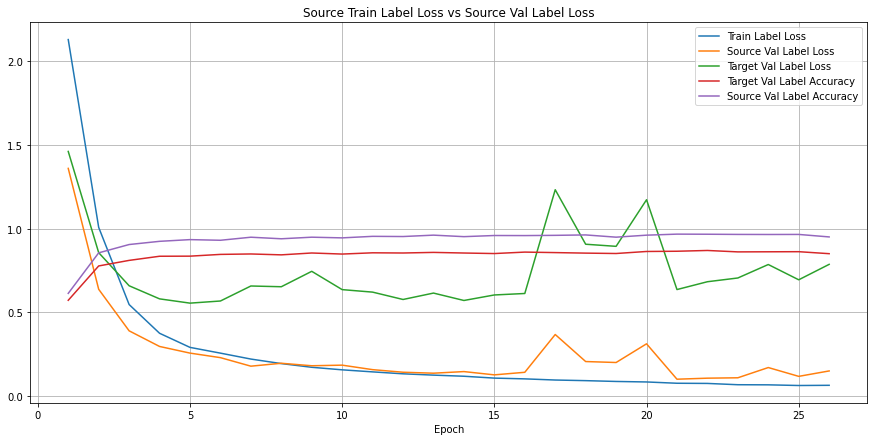

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

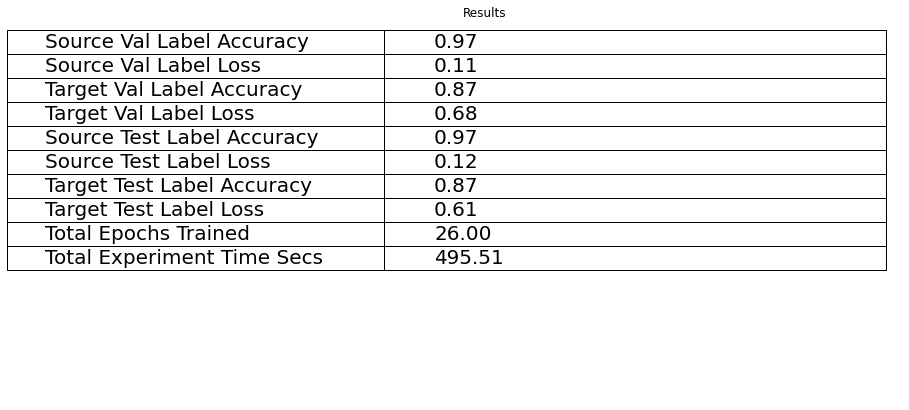

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

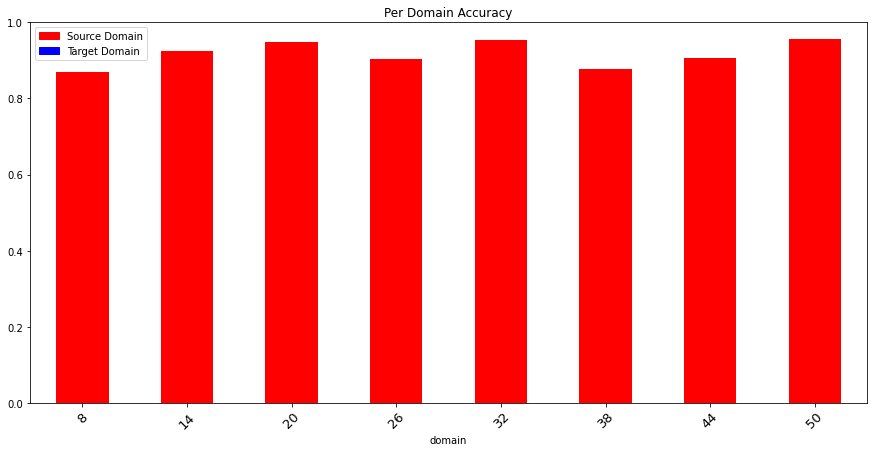

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9672395833333334 Target Test Label Accuracy: 0.8687760416666667
Source Val Label Accuracy: 0.9661979166666667 Target Val Label Accuracy: 0.8690625


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "cnn_3:oracle.run1.framed-oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d